**Student Name**: Zhibing Liu\
**Student Number**: 1010506515

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
!pip install pingouin
import pingouin as pg
from math import sqrt
import statsmodels.stats.power as smp
from statsmodels.stats.power import TTestIndPower

## **2. Clean the dataset for further use**

In [79]:
data = pd.read_csv('../INF2178_A4_data.csv')
data.head()

,Unnamed: 0,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444


In [80]:
# Filter out CDR 2.0
data_filtered = data[data['CDR'] != 2.0]

data_relevant = data_filtered[['Subject ID', 'CDR', 'Visit', 'eTIV', 'nWBV', 'Age']]
data_relevant.head()

,Subject ID,CDR,Visit,eTIV,nWBV,Age
0,OAS2_0001,0.0,1,1987,0.696,87
1,OAS2_0001,0.0,2,2004,0.681,88
2,OAS2_0002,0.5,1,1678,0.736,75
3,OAS2_0002,0.5,2,1738,0.713,76
4,OAS2_0004,0.0,1,1215,0.710,88


## **3. Exploratory Data Analysis (EDA) & Interaction Plots**

In [81]:
# The describe() method by default includes these statistics: count, mean, std, min, 25%, 50%, 75%, max.
summary_statistics = data_relevant.describe()

# The describe() method by default includes these statistics: count, mean, std, min, 25%, 50%, 75%, max.

summary_statistics

,CDR,Visit,eTIV,nWBV,Age
count,291.000000,291.000000,291.000000,291.000000,291.000000
mean,0.283505,1.484536,1478.243986,0.731636,76.323024
std,0.341704,0.500622,176.885017,0.037247,7.537867
min,0.000000,1.000000,1106.000000,0.646000,60.000000
25%,0.000000,1.000000,1345.500000,0.703000,71.000000
50%,0.000000,1.000000,1461.000000,0.732000,76.000000
75%,0.500000,2.000000,1569.000000,0.756000,81.000000
max,1.000000,2.000000,2004.000000,0.837000,96.000000


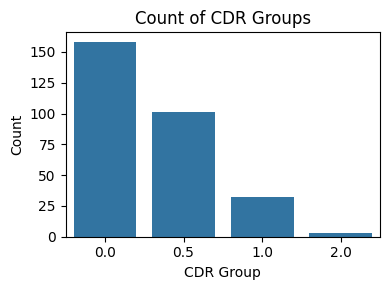

In [82]:
# Set up the figure size for the histogram
plt.figure(figsize=(4, 3))

# Create a histogram for the count of each CDR group excluding 2.0
sns.countplot(x='CDR', data=data)
plt.title('Count of CDR Groups')
plt.xlabel('CDR Group')
plt.ylabel('Count')

# Show the plot
plt.tight_layout()
plt.show()

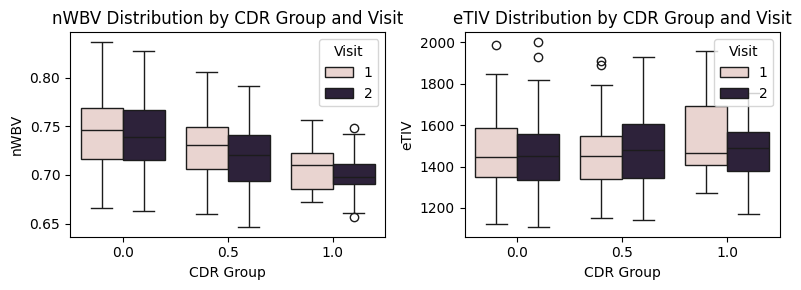

In [83]:
# Setting up the figure size
plt.figure(figsize=(8, 3))

# Plotting nWBV distributions by CDR Group and Visit
plt.subplot(1, 2, 1)
sns.boxplot(x='CDR', y='nWBV', hue='Visit', data=data_relevant)
plt.title('nWBV Distribution by CDR Group and Visit')
plt.xlabel('CDR Group')
plt.ylabel('nWBV')

# Plotting eTIV distributions by CDR Group and Visit
plt.subplot(1, 2, 2)
sns.boxplot(x='CDR', y='eTIV', hue='Visit', data=data_relevant)
plt.title('eTIV Distribution by CDR Group and Visit')
plt.xlabel('CDR Group')
plt.ylabel('eTIV')

# Adjusting the layout for better readability
plt.tight_layout()
plt.show()

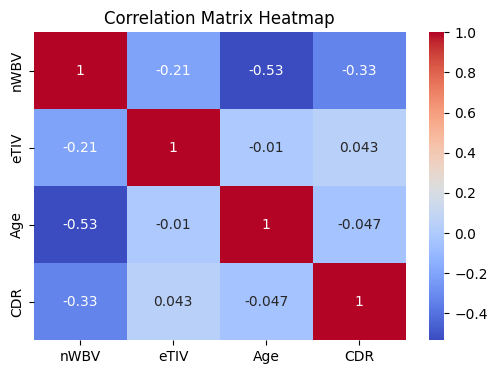

In [84]:
# Selecting a subset of variables for correlation analysis
selected_variables = data_relevant[['nWBV', 'eTIV', 'Age', 'CDR']]

# Calculating the correlation matrix
corr_matrix = selected_variables.corr()

# Generating a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

## **Mixed-Effect ANOVA Result for Research question 1**


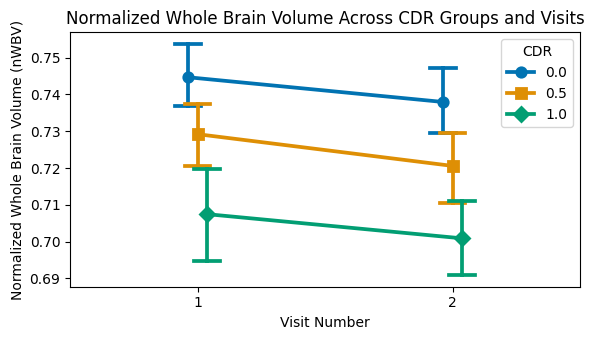

In [85]:
# Output plots
plt.figure(figsize=(6, 3.5))
sns.pointplot(data=data_relevant, x='Visit', y='nWBV', hue='CDR', dodge=True, markers=['o', 's', 'D', '^', '*'],
              capsize=.1, palette='colorblind')
plt.title('Normalized Whole Brain Volume Across CDR Groups and Visits')
plt.ylabel('Normalized Whole Brain Volume (nWBV)')
plt.xlabel('Visit Number')
plt.legend(title='CDR')
plt.tight_layout()

plt.show()

In [86]:
# Make copy of the dateset
Re1 = data_relevant.copy()

Re1['Dementia_Group'] = Re1['CDR'].apply(lambda x: f'CDR_{x}')

# 1. Mixed-Design ANOVA
aov = pg.mixed_anova(dv='nWBV', within='Visit', between='Dementia_Group', subject='Subject ID', data=Re1)
aov

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Dementia_Group,0.040265,2,115,0.020133,7.722996,7.126207e-04,0.118409,NaN
1,Visit,0.004851,1,115,0.004851,73.062698,6.137789e-14,0.388502,1.0
2,Interaction,0.000389,2,115,0.000194,2.928320,5.748719e-02,0.048459,NaN


In [87]:
# Test of Normality
normality_test = pg.normality(data=Re1, dv='nWBV', group='Dementia_Group')
normality_test

,W,pval,normal
Dementia_Group,,,
CDR_0.0,0.990402,0.362252,True
CDR_0.5,0.993523,0.914782,True
CDR_1.0,0.985710,0.937991,True


In [88]:
# Test of normality
normality_test_visit = pg.normality(data=Re1, dv='nWBV', group='Visit')
normality_test_visit

,W,pval,normal
Visit,,,
1,0.990075,0.372060,True
2,0.989589,0.376898,True


In [89]:
# Test for Homogeneity of Variances
homogeneity_test = pg.homoscedasticity(data=Re1, dv='nWBV', group='Dementia_Group')
print("\nHomogeneity of Variances Test Results:")
homogeneity_test


Homogeneity of Variances Test Results:


,W,pval,equal_var
levene,4.369772,0.013504,False


## **Mixed-Effect ANOVA Result for Research question 2**

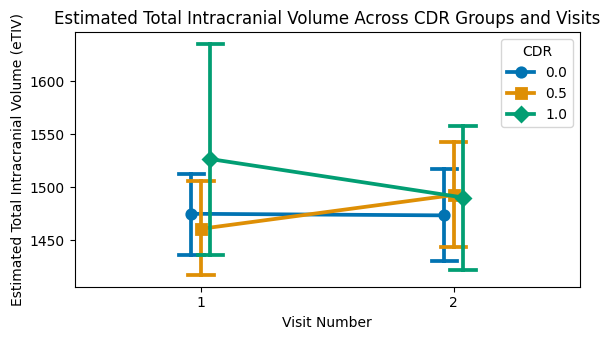

In [90]:
# Output plots
plt.figure(figsize=(6, 3.5))
sns.pointplot(data=data_relevant, x='Visit', y='eTIV', hue='CDR', dodge=True, markers=['o', 's', 'D', '^', '*'],
              capsize=.1, palette='colorblind')
plt.title('Estimated Total Intracranial Volume Across CDR Groups and Visits')
plt.ylabel('Estimated Total Intracranial Volume (eTIV)')
plt.xlabel('Visit Number')
plt.legend(title='CDR')
plt.tight_layout()
plt.show()


In [93]:
# Make copy of the dataset
Re2 = data_relevant.copy()

# Map CDR to a more descriptive category name if needed
Re2['Dementia_Group'] = Re2['CDR'].apply(lambda x: f'CDR_{x}')

# Mixed-Design ANOVA with the correct column name for Subject ID
aov = pg.mixed_anova(dv='eTIV', within='Visit', between='Dementia_Group', subject='Subject ID', data=Re2)
print("\nMixed-Design ANOVA Results:")
aov


Mixed-Design ANOVA Results:


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Dementia_Group,24593.950156,2,115,12296.975078,0.190023,0.827199,0.003294,NaN
1,Visit,5034.322034,1,115,5034.322034,8.553337,0.004155,0.069228,1.0
2,Interaction,15135.993025,2,115,7567.996512,12.858062,0.000009,0.182752,NaN


In [96]:
# Test of Normality by Dementia Group
normality_test = pg.normality(data=Re2, dv='eTIV', group='Dementia_Group')
print("\nTest of Normality by Dementia Group Results:")
normality_test


Test of Normality by Dementia Group Results:


,W,pval,normal
Dementia_Group,,,
CDR_0.0,0.968820,0.001220,False
CDR_0.5,0.968763,0.016949,False
CDR_1.0,0.958777,0.254224,True


In [98]:
# Test of Normality by Visit
normality_test_visit = pg.normality(data=Re2, dv='eTIV', group='Visit')
print("\nTest of Normality by Visit Results:")
normality_test_visit



Test of Normality by Visit Results:


,W,pval,normal
Visit,,,
1,0.969209,0.001908,False
2,0.976429,0.015378,False


In [100]:
# Test for Homogeneity of Variances
homogeneity_test = pg.homoscedasticity(data=Re2, dv='eTIV', group='Dementia_Group')
print("\nHomogeneity of Variances Test Results:")
homogeneity_test


Homogeneity of Variances Test Results:


,W,pval,equal_var
levene,0.3103,0.733472,True


## **Power plot for t-tests**

<Figure size 300x100 with 0 Axes>

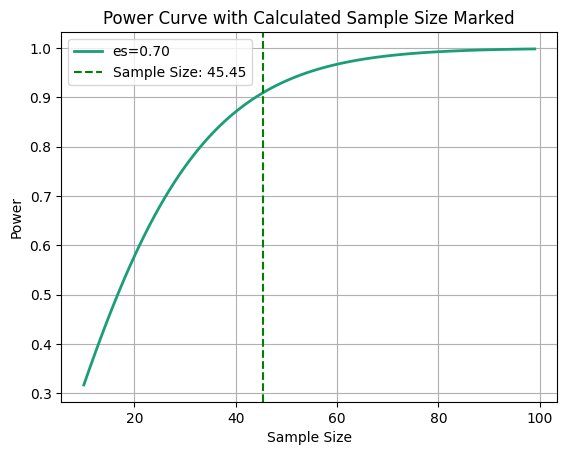

In [106]:
# Parameters for the power analysis
effect_size = 0.7  # Cohen's d
alpha = 0.05       # Significance level
power = 0.91       # Desired power

# Initialize the power analysis object for t-tests
power_analysis = TTestIndPower()

# Calculate the sample size
sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=1, alternative='two-sided')

# Define the range of sample sizes for plotting
sample_sizes_plot = np.array(range(10, 100))

# Generating the power curve with the calculated sample size marked
plt.figure(figsize=(3, 1))
power_analysis.plot_power(dep_var='nobs',
                          nobs=sample_sizes_plot,
                          effect_size=np.array([effect_size]),
                          alpha=alpha)

# Marking the calculated sample size
plt.axvline(x=sample_size, color='g', linestyle='--', label=f'Sample Size: {sample_size:.2f}')
plt.legend()
plt.title('Power Curve with Calculated Sample Size Marked')
plt.xlabel('Sample Size')
plt.ylabel('Power')
plt.grid(True)
plt.show()
